# CVS Web Scraper
Author: Stephen Kita

Date: 21 July 2020

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import time
import random

## Initialize Global Variables

In [ ]:
my_header = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36'}
base_url = 'https://www.cvs.com/store-locator/cvs-pharmacy-locations/'
df_cvs = pd.DataFrame(columns=('state', 'town', 'count'))
states = ["Arkansas", "Arizona", "California", "Colorado", "Connecticut", 
          "Delaware", "District-of-Columbia", "Florida", "Georgia", "Hawaii", 
          "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", 
          "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", 
          "Mississippi", "Montana", "Nebraska", "Nevada", "New-Hampshire", "New-Jersey", 
          "New-Mexico", "New-York", "North-Carolina", "North-Dakota", "Ohio", "Oklahoma", 
          "Oregon", "Pennsylvania", "Puerto-Rico", "Rhode-Island", "South-Carolina", 
          "South-Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont",
          "Washington", "West-Virginia", "Wisconsin", "Wyoming"]

## Scrape Website and Save to CSV

In [ ]:
for state in states:
    url = base_url + state
    response = requests.get(url, headers=my_header)
    
    if response.ok:
        print(f'Scraping {state}...')
        text = BeautifulSoup(response.text, 'html.parser')
        text_towns = text.find('div', 'states').select('li')
        for town_seq in text_towns:
            town_seq = town_seq.get_text().strip()
            town = ' '.join(re.findall('\w*[a-z]', town_seq))
            count = int(re.findall('\w*\d+', town_seq)[0])
            df_cvs = df_cvs.append({'state': state,'town': town,'count': count}, ignore_index=True)
        print('... complete')
    else:
        print('#'*50)
        print(f'Failed to scrape {state}')
        print('#'*50)

    time.sleep(random.randint(5,10))

df_cvs['state'] = df_cvs['state'].str.replace('-',' ')
df_cvs.to_csv('csv-locs.csv', index=False)
print('Writing to .csv complete!')

In [181]:
df_cvs.to_csv('csv-locs.csv', index=False)

## Load CSV and Perform EDA

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import figure
plt.style.use('ggplot')
%matplotlib inline
df_cvs = pd.read_csv('csv-locs.csv')
df_cvs.head()

,state,town,count
0,Alaska,Anchorage,2
1,Alaska,Wasilla,2
2,Alabama,Alabaster,2
3,Alabama,Albertville,1
4,Alabama,Aliceville,1


In [26]:
df_states = df_cvs.groupby('state').agg({'count':['count','sum']})['count'].sort_values('sum', ascending=False)
df_states.head()

,count,sum
state,,
California,398,1175
Florida,267,874
Texas,280,843
New York,293,572
Pennsylvania,278,487


**Reserach Question:** How does the total number of CVS stores compare to the *state* population?

In [27]:
df_states_pop = pd.read_csv('state-pops.csv')
df_states_pop['state'] = df_states_pop['state'].str.strip('.')    # read state data

df_states = pd.merge(df_states_pop,df_states,on='state')    # combine with state cvs counts
df_states.sort_values('state_pop',ascending=False,inplace=True,ignore_index=True)
df_states.rename({'count':'city_count','sum':'cvs_count'},axis=1,inplace=True)
df_states.head()

,state,state_pop,city_count,cvs_sum
0,California,39512223,398,1175
1,Texas,28995881,280,843
2,Florida,21477737,267,874
3,New York,19453561,293,572
4,Pennsylvania,12801989,278,487


Text(0.5, 1.0, 'CVS Stores per State by Population')

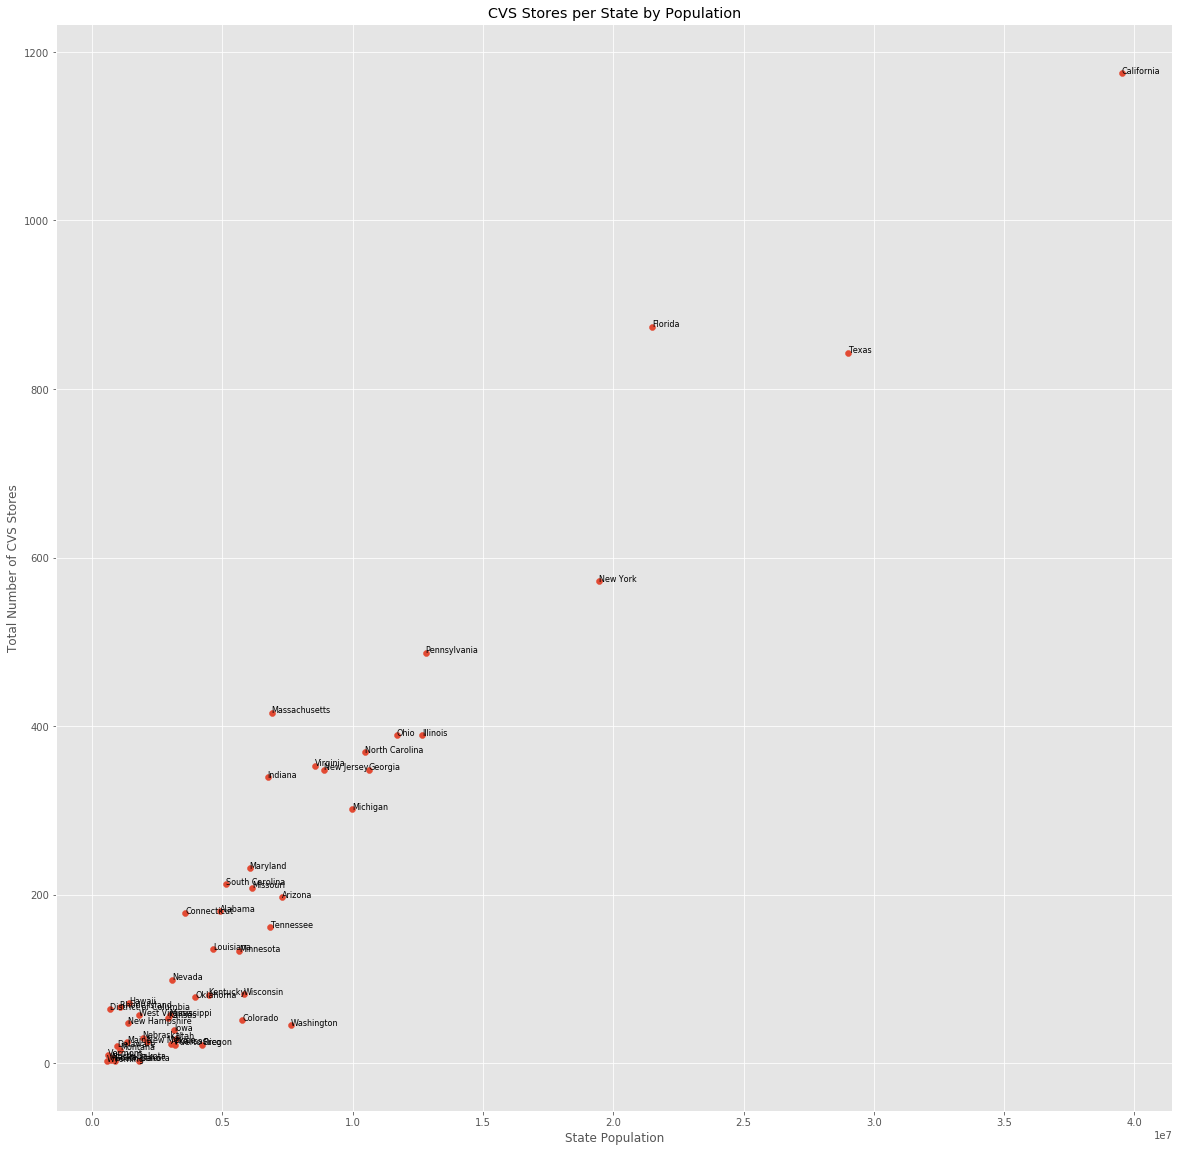

In [29]:
fig, ax = plt.subplots(figsize=(20,20))
plt.scatter(df_states['state_pop'], df_states['cvs_sum'])
for i, txt in enumerate(df_states.state):
    ax.annotate(txt, (df_states['state_pop'][i], df_states['cvs_sum'][i]),   # annotations throw off scaling
               size=8)

plt.xlabel('State Population')
plt.ylabel('Total Number of CVS Stores')
plt.title('CVS Stores per State by Population')

Linear regression in MS Excel, trendline: y = 3E-05 * x, R² = 0.9153. Equivalent to 1 CVS per 33,333 people.

Group data by CVS count under/over expected demand.

In [30]:
df_states['under'] = ((df_states['cvs_sum'] / df_states['state_pop']) < 3E-5)
df_states['under_count'] = round(df_states['state_pop']/33333) - df_states['cvs_sum']
df_states.head()

,state,state_pop,city_count,cvs_sum,under,under_count
0,California,39512223,398,1175,True,10.0
1,Texas,28995881,280,843,True,27.0
2,Florida,21477737,267,874,False,-230.0
3,New York,19453561,293,572,True,12.0
4,Pennsylvania,12801989,278,487,False,-103.0


## City Research

**Reserach Question:** How does the total number of CVS stores compare to *city* populations?

In [33]:
df_cities_pop = pd.read_csv('city-pops.csv')
df_cities_pop.state = df_cities_pop.state.str.strip()
df_cities = pd.merge(df_cities_pop, df_cvs, left_on=['state','city'], right_on=['state','town'])
df_cities.drop('town', axis=1, inplace=True)
df_cities.sort_values('state',ascending=False,inplace=True,ignore_index=True)
df_cities.rename({'count':'cvs_count'},axis=1,inplace=True)
df_cities

,state,city,city_pop,cvs_count
0,Wyoming,Cheyenne,64235,1
1,Wyoming,Casper,57931,1
2,Wisconsin,Racine,76760,2
3,Wisconsin,Appleton,74098,4
4,Wisconsin,West Allis,59890,3
5,Wisconsin,Janesville,64575,3
6,Wisconsin,Oshkosh,67004,2
7,Wisconsin,Eau Claire,68802,2
8,Wisconsin,Waukesha,72299,3
9,Wisconsin,Milwaukee,590157,8


Text(0.5, 1.0, 'CVS Stores per City by Population')

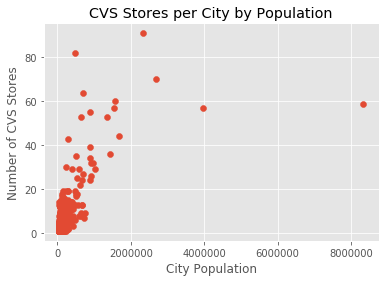

In [34]:
plt.scatter(df_cities['city_pop'], df_cities['cvs_count'])
plt.xlabel('City Population')
plt.ylabel('Number of CVS Stores')
plt.title('CVS Stores per City by Population')

Linear regression in MS Excel, trendline is the same as the states: y = 3E-05 * x, R² = 0.9153. Equivalent to 1 CVS per 33,333 people.

Group cities by CVS count under/over expected demand.

In [35]:
df_cities['under'] = ((df_cities['cvs_count'] / df_cities['city_pop']) < 3E-5)
df_cities['under_count'] = round(df_cities['city_pop']/33333) - df_cities['cvs_count']
df_cities.head()

,state,city,city_pop,cvs_count,under,under_count
0,Wyoming,Cheyenne,64235,1,True,1.0
1,Wyoming,Casper,57931,1,True,1.0
2,Wisconsin,Racine,76760,2,True,0.0
3,Wisconsin,Appleton,74098,4,False,-2.0
4,Wisconsin,West Allis,59890,3,False,-1.0


## Comapring States and Cities

**Reserach Question:** What states should open stores where they already have a presence? and what states should open stores in new cities?

In [42]:
pd.merge(df_states, df_cities, how='left', on='state', suffixes=('_state','_city')).sort_values('state',ignore_index=True)

,state,state_pop,city_count,cvs_count_state,under_state,under_count_state,city,city_pop,cvs_count_city,under_city,under_count_city
0,Alabama,4903185,100,180,False,-33.0,Huntsville,200574.0,9.0,False,-3.0
1,Alabama,4903185,100,180,False,-33.0,Madison,51593.0,3.0,False,-1.0
2,Alabama,4903185,100,180,False,-33.0,Birmingham,209403.0,12.0,False,-6.0
3,Alabama,4903185,100,180,False,-33.0,Montgomery,198525.0,11.0,False,-5.0
4,Alabama,4903185,100,180,False,-33.0,Mobile,188720.0,13.0,False,-7.0
5,Alabama,4903185,100,180,False,-33.0,Decatur,54445.0,2.0,False,0.0
6,Alabama,4903185,100,180,False,-33.0,Hoover,85768.0,4.0,False,-1.0
7,Alabama,4903185,100,180,False,-33.0,Dothan,68941.0,4.0,False,-2.0
8,Alabama,4903185,100,180,False,-33.0,Auburn,66259.0,4.0,False,-2.0
9,Alabama,4903185,100,180,False,-33.0,Tuscaloosa,101129.0,7.0,False,-4.0


***Add back in and and filter the states that had no cities included in the city population dataset (pop < 50k)***

In [53]:
x = pd.merge(df_states, df_cvs_under.groupby('state').agg({'city_under_count':'sum'}), on='state')
x = x.append(df_states[df_states['under']==True]).drop_duplicates('state')
x[x['city_under_count'].isna()].assign(city_under_count=0)   # six states were left out

,state,state_pop,city_count,state_cvs_sum,mean,under,state_under_count,city_under_count
24,Louisiana,4648794,58,135,2.327586,True,4.0,0
30,Puerto Rico,3193694,14,22,1.571429,True,74.0,0
34,Mississippi,2976149,40,57,1.425000,True,32.0,0
42,Maine,1344212,18,25,1.388889,True,15.0,0
45,Delaware,973764,14,20,1.428571,True,9.0,0
50,Vermont,623989,9,9,1.000000,True,10.0,0


In [55]:
df_cvs_under = x.fillna(0)
df_cvs_under

,state,state_pop,city_count,state_cvs_sum,mean,under,state_under_count,city_under_count
0,California,39512223,398,1175,2.952261,True,10.0,134.0
1,Texas,28995881,280,843,3.010714,True,27.0,29.0
2,New York,19453561,293,572,1.952218,True,12.0,196.0
3,Washington,7614893,29,45,1.551724,True,183.0,48.0
4,Arizona,7278717,48,197,4.104167,True,21.0,14.0
5,Tennessee,6829174,78,161,2.064103,True,44.0,19.0
6,Wisconsin,5822434,47,82,1.744681,True,93.0,13.0
7,Colorado,5758736,29,51,1.758621,True,122.0,52.0
8,Minnesota,5639632,78,133,1.705128,True,36.0,5.0
9,Kentucky,4467673,45,81,1.800000,True,53.0,5.0


In [56]:
df_cvs_under.to_csv('city_sum_under.csv', index=False)

# Archive - not useful

Codes and graphs from EDA that were not helpful.

Text(0.5, 1.0, 'CVS Stores per State')

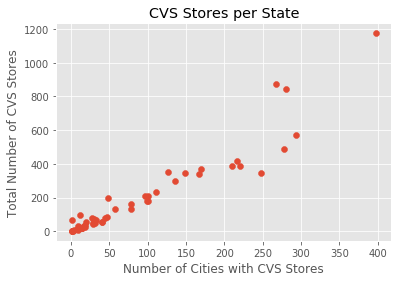

In [99]:
# Archive - not useful

# plt.scatter(df_states['count'], df_states['sum'])
# plt.xlabel('Number of Cities with CVS Stores')
# plt.ylabel('Total Number of CVS Stores')
# plt.title('CVS Stores per State')

Text(0.5, 1.0, 'CVS Stores per State')

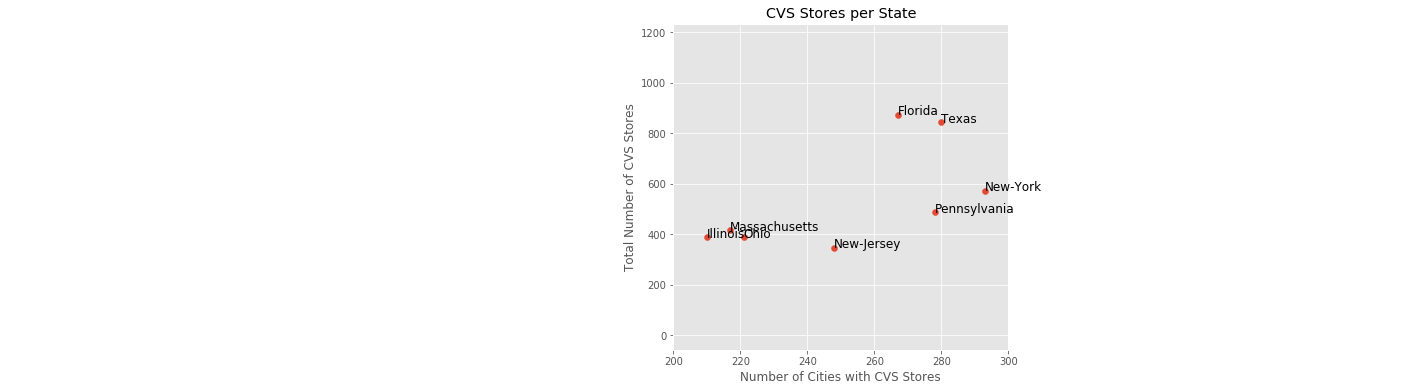

In [142]:
# Archive - not useful

# fig, ax = plt.subplots(figsize=(6,6))
# ax.set_xlim(xmin=200,xmax=300)
# ax.scatter(df_states['count'], df_states['sum'])
# for i, txt in enumerate(df_states.index):
#     ax.annotate(txt, (df_states['count'][i], df_states['sum'][i]),   # annotations throw off scaling
#                size=12)
# # ax.margins(x=-.3,y=-.3)   # save for later
# plt.xlabel('Number of Cities with CVS Stores')
# plt.ylabel('Total Number of CVS Stores')
# plt.title('CVS Stores per State')